In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
import psutil
import joblib

In [47]:
df = pd.read_csv('phishing_with_features_final.csv')
df.sample(5)

,url,type,url_length,hostname_length,path_length,query_length,has_ip,has_at_symbol,count_dots,count_hyphens,...,max_consecutive_letters,hostname_digit_ratio,path_digit_ratio,domain_length,tld_length,vowel_consonant_ratio,unique_char_ratio,numeric_domain_ratio,shortening_service,suspicious_tld
132437,alumniclass.com/high-school-alumni-classmates/...,benign,69,0,69,0,False,False,1,3,...,11,0.000000,0.057971,11,3,0.368421,0.347826,0.000000,0,0
372703,http://www.olivesys.com.ve/dropbox/dpbx/,phishing,40,19,14,0,False,False,3,0,...,8,0.000000,0.000000,8,6,0.225806,0.500000,0.000000,0,0
164054,divxturka.net/divx-download/338188-sugar-town-...,benign,57,0,57,0,False,False,2,5,...,9,0.000000,0.175439,9,3,0.315789,0.438596,0.000000,0,0
281885,http://io9.com/why-is-there-a-hole-in-airplane...,benign,84,7,70,0,False,False,1,8,...,9,0.142857,0.142857,3,3,0.385965,0.321429,0.166667,0,0
333906,http://www.albondon.org/index.php/the-news/not...,phishing,143,16,120,0,False,False,3,17,...,12,0.000000,0.016667,8,3,0.403509,0.181818,0.000000,0,0


In [48]:
df.isnull().sum()

url                        0
type                       0
url_length                 0
hostname_length            0
path_length                0
query_length               0
has_ip                     0
has_at_symbol              0
count_dots                 0
count_hyphens              0
count_slashes              0
count_underscores          0
count_question_marks       0
count_equals               0
count_ampersands           0
count_digits               0
count_uppercase            0
count_lowercase            0
digit_ratio                0
uppercase_ratio            0
special_char_count         0
subdomain_count            0
max_segment_length         0
avg_segment_length         0
url_entropy                0
hostname_entropy           0
path_entropy               0
uses_https                 0
suspicious_words           0
count_percent              0
count_semicolons           0
count_colons               0
count_brackets             0
count_plus                 0
count_asterisk

In [49]:
df.type.unique()

array(['phishing', 'benign'], dtype=object)

In [50]:
df.type = df.type.apply(lambda x: 1 if x=='phishing' else 0)

In [51]:
df.sample(5)

,url,type,url_length,hostname_length,path_length,query_length,has_ip,has_at_symbol,count_dots,count_hyphens,...,max_consecutive_letters,hostname_digit_ratio,path_digit_ratio,domain_length,tld_length,vowel_consonant_ratio,unique_char_ratio,numeric_domain_ratio,shortening_service,suspicious_tld
96466,zaxxon.freeshell.org/FanFic/Other/Wheel_of_Time/,0,48,0,48,0,False,False,2,0,...,9,0.0,0.0,9,3,0.375000,0.416667,0.0,0,0
202355,youtube.com/watch?v=FdlCH_9ZSuk,0,31,0,17,13,False,False,1,0,...,7,0.0,0.0,7,3,0.280000,0.774194,0.0,0,0
223202,thecanadianencyclopedia.com/index.cfm?PgNm=TCE...,0,67,0,37,29,False,False,2,0,...,23,0.0,0.0,23,3,0.365385,0.432836,0.0,0,0
625010,www.angelfire.com/art/WebSites/,1,31,0,31,0,False,False,2,0,...,9,0.0,0.0,9,3,0.346154,0.548387,0.0,0,0
418899,music.northwestern.edu/,0,23,0,23,0,False,False,2,0,...,12,0.0,0.0,12,3,0.350000,0.652174,0.0,0,0


In [52]:
df.drop(columns=['url'], inplace=True, errors='ignore')

# Integer columns (counts and lengths)
int_cols = ['url_length', 'hostname_length', 'path_length', 'query_length',
            'count_dots', 'count_hyphens', 'count_slashes', 'count_underscores',
            'count_question_marks', 'count_equals', 'count_ampersands', 
            'count_digits', 'count_uppercase', 'count_lowercase',
            'special_char_count', 'subdomain_count', 'max_segment_length',
            'suspicious_words', 'count_percent', 'count_semicolons', 
            'count_colons', 'count_brackets', 'count_plus', 'count_asterisk',
            'path_depth', 'query_params', 'max_consecutive_digits',
            'max_consecutive_letters', 'domain_length', 'tld_length']

for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

# Boolean columns
bool_cols = ['has_ip', 'has_at_symbol', 'uses_https', 'shortening_service', 'suspicious_tld']

for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype('bool')

# Float columns (ratios and entropy values)
float_cols = ['digit_ratio', 'uppercase_ratio', 'avg_segment_length',
              'url_entropy', 'hostname_entropy', 'path_entropy',
              'hostname_digit_ratio', 'path_digit_ratio', 
              'vowel_consonant_ratio', 'unique_char_ratio', 'numeric_domain_ratio']

for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

In [53]:
df.dtypes

type                         int64
url_length                   int16
hostname_length              int16
path_length                  int16
query_length                 int16
has_ip                        bool
has_at_symbol                 bool
count_dots                    int8
count_hyphens                 int8
count_slashes                 int8
count_underscores             int8
count_question_marks          int8
count_equals                  int8
count_ampersands              int8
count_digits                 int16
count_uppercase              int16
count_lowercase              int16
digit_ratio                float32
uppercase_ratio            float32
special_char_count           int16
subdomain_count               int8
max_segment_length            int8
avg_segment_length         float32
url_entropy                float32
hostname_entropy           float32
path_entropy               float32
uses_https                    bool
suspicious_words              int8
count_percent       

In [54]:
class_count0, class_count1 = df['type'].value_counts()
class_count0, class_count1

(428103, 223088)

In [55]:
X= df.drop('type', axis=1)
y = df['type']

In [56]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [57]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

type
0    321077
1    321077
Name: count, dtype: int64

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [59]:
def tune_phishing_models(X_train, y_train, scoring='accuracy', cv=3, verbose=0):
    models_params = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=500),
            'params': {
                'model__C': [0.1, 1, 10],
                'model__penalty': ['l2'],
                'model__solver': ['lbfgs']
            }
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'params': {}  # no tuning needed
        },
        'Linear SVM': {
            'model': LinearSVC(max_iter=1000),
            'params': {
                'model__C': [0.1, 1, 10]
            }
        }
    }

    best_models = {}

    for name, config in models_params.items():
        print(f"\n🔍 Tuning: {name}")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', config['model'])
        ])

        grid = GridSearchCV(
            pipeline,
            config['params'],
            cv=cv,
            scoring=scoring,
            verbose=verbose,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)

        print(f"✅ {name} best score: {grid.best_score_:.4f}")
        print(f"🔧 Best params: {grid.best_params_}")
        best_models[name] = grid.best_estimator_

    return best_models

In [60]:
# tune_phishing_models(X_train_scaled, y_train_resampled) 

In [61]:
model = LogisticRegression(C=10, penalty='l2', solver='lbfgs', verbose=0)

In [62]:
model.fit(X_train_scaled, y_train_resampled)

C:\Users\sinan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [63]:
model.score(X_test_scaled, y_test)

0.8816570228135481

In [64]:
y_predicted = model.predict(X_test_scaled)

In [65]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91    107026
           1       0.84      0.81      0.82     55772

    accuracy                           0.88    162798
   macro avg       0.87      0.86      0.87    162798
weighted avg       0.88      0.88      0.88    162798



In [66]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Change threshold
threshold = 0.43  # Try 0.4 or even 0.3
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90    107026
           1       0.79      0.85      0.82     55772

    accuracy                           0.87    162798
   macro avg       0.85      0.87      0.86    162798
weighted avg       0.88      0.87      0.87    162798



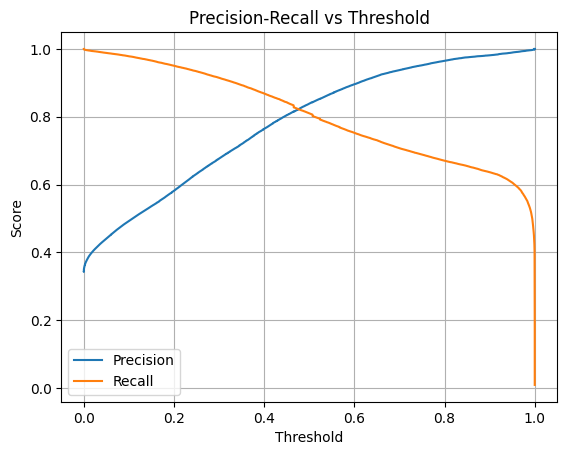

In [67]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)

In [68]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Filter where precision is at least 0.75
mask = precision[:-1] >= 0.75  # exclude the last threshold (no corresponding value)
filtered_thresholds = thresholds[mask]
filtered_recalls = recall[:-1][mask]

# Find threshold with maximum recall
if len(filtered_thresholds) > 0:
    best_idx = np.argmax(filtered_recalls)
    best_threshold = filtered_thresholds[best_idx]
    best_recall = filtered_recalls[best_idx]
    best_precision = precision[:-1][mask][best_idx]
    print(f"Best threshold: {best_threshold:.2f} with precision: {best_precision:.2f}, recall: {best_recall:.2f}")
else:
    print("No threshold found with precision >= 0.75")


Best threshold: 0.38 with precision: 0.75, recall: 0.88


In [69]:
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [78]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
background_data = X_train_scaled_df.sample(n=500, random_state=42)
background_data.to_csv("shap_background.csv")

In [89]:
X_train_scaled[:2]

array([[-0.67342836, -0.69020253, -0.72941065, -0.01182228, -0.16689594,
        -0.05106274, -0.9066106 , -0.5014408 , -1.0661869 ,  0.5692556 ,
         1.6833273 ,  0.16114105, -0.3571507 , -0.21715896,  0.30896574,
        -0.8974908 ,  0.22866759,  2.3163798 , -0.16480286, -0.458226  ,
        -0.6514256 , -0.7038808 ,  0.71113026, -0.7801491 , -0.3055278 ,
        -0.1921537 , -0.19746687, -0.12095936, -0.07132322, -0.6910534 ,
        -0.07814478, -0.09841247, -0.00426785, -0.38396218,  0.17079912,
        -0.4280463 , -0.85856056, -0.2175633 , -0.5452844 , -0.6074724 ,
         0.04182565, -0.40647733,  2.0221822 , -0.21349843, -0.11584757,
        -0.06374765],
       [-0.7179771 , -0.69020253, -0.31125984, -0.37804693, -0.16689594,
        -0.05106274, -0.20584986, -0.5014408 , -0.5407158 , -0.36703834,
        -0.5405496 , -0.43549725, -0.3571507 , -0.39415285, -0.26045004,
        -0.6875325 , -0.36747685, -0.44514254, -0.34734   , -0.458226  ,
        -0.6514256 , -0.70388

In [84]:
X_train.columns

Index(['url_length', 'hostname_length', 'path_length', 'query_length',
       'has_ip', 'has_at_symbol', 'count_dots', 'count_hyphens',
       'count_slashes', 'count_underscores', 'count_question_marks',
       'count_equals', 'count_ampersands', 'count_digits', 'count_uppercase',
       'count_lowercase', 'digit_ratio', 'uppercase_ratio',
       'special_char_count', 'subdomain_count', 'max_segment_length',
       'avg_segment_length', 'url_entropy', 'hostname_entropy', 'path_entropy',
       'uses_https', 'suspicious_words', 'count_percent', 'count_semicolons',
       'count_colons', 'count_brackets', 'count_plus', 'count_asterisk',
       'path_depth', 'query_params', 'max_consecutive_digits',
       'max_consecutive_letters', 'hostname_digit_ratio', 'path_digit_ratio',
       'domain_length', 'tld_length', 'vowel_consonant_ratio',
       'unique_char_ratio', 'numeric_domain_ratio', 'shortening_service',
       'suspicious_tld'],
      dtype='object')

In [72]:
X_train.shape

(488393, 46)

Text(0.5, 36.72222222222221, 'Predicted Label')

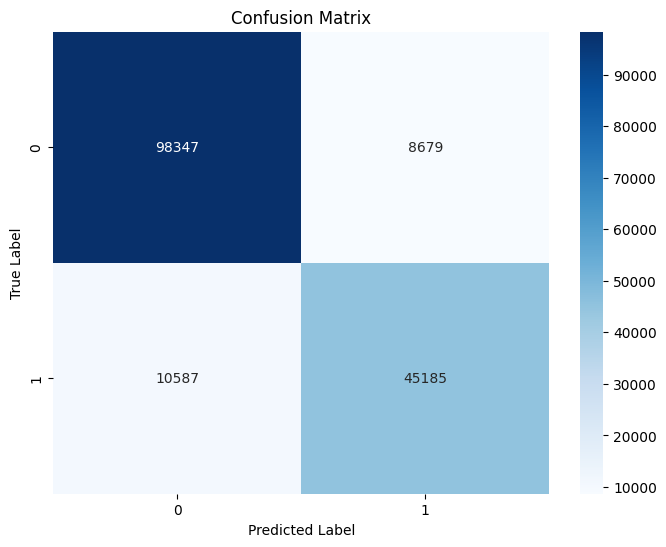

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_adjusted=model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [ ]:
model.pred